# Diagnóstico Inicial do Cancelamento - CAHL

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_percentage(df, x, y, xlabel):   
    counts = df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    print(counts)
    g = sns.catplot(x=x, y='percent', hue=y, data=counts, kind='bar')
    
    g.set(xlabel = xlabel)
    
    new_title = 'Cancelamento'
    g._legend.set_title(new_title)
    # replace labels
    new_labels = ['Não', 'Sim']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    plt.show()

df = pd.read_csv('/home/ramon/extrator/survival/evasao-100.csv')

In [2]:
def permutation_test(events, obs_diff, n1):
    n = len(events)
    n2 = n-n1
    idxs = np.arange(0, n)



    values = []
    for i in range(10000):
        foo = np.full(n, False)
        idx_a = np.random.choice(idxs, n1, replace=False)
        foo[idx_a] = True

        diff = np.abs(events[foo].mean() - events[~foo].mean())
        values.append(diff)

    return (np.mean(np.array(values) > obs_diff))

def proportion_test(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    counts = df[idx].groupby(col_name)['event'].mean().values
    obs_diff = np.abs(counts[0] - counts[1])
    n1 = df[idx][col_name].value_counts().values[0]
    events = df.loc[idx, 'event'].values
    
    return (permutation_test(events, obs_diff, n1))

from statsmodels.stats.proportion import proportions_ztest

def proportion_test2(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    count = df[idx].groupby(col_name)['event'].sum().values
    nobs = df[idx].groupby(col_name)['event'].count().values

    stat, pval = proportions_ztest(count, nobs)
    return pval

In [3]:
centro  = 'CAHL'
df = df[df.centro == centro]

In [4]:
df.groupby('time')['event'].value_counts()

time  event
1     0        3296
      1         745
2     0        2913
      1         362
3     0        2633
      1         219
4     0        2254
      1         134
5     0        2108
      1          99
6     0        1822
      1          59
7     0        1666
      1          33
8     0        1429
      1          23
9     0         972
      1          31
10    0         605
      1          23
11    0         446
      1          31
12    0         254
      1          21
13    0         169
      1          17
14    0          82
      1           5
15    0          60
      1           6
16    0          30
      1           4
17    0          13
18    0           6
      1           1
19    0           2
Name: event, dtype: int64

# Perfil dos Estudantes na Amostra

- 55% cancelaram
- 89% possuem cidade de origem diferente da cidade do campus
- 60% são do sexo feminino
- Idade média dos estudantes é 25
- Há 4041 números de matrículas

In [5]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

print(df[idx]['event'].value_counts(normalize=True))

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

print(df[idx]['sexo'].value_counts(normalize=True))

print(df[idx]['idade_ingresso'].mean())

print(df.matricula.nunique())

0    0.551349
1    0.448651
Name: event, dtype: float64
1    0.892353
0    0.107647
Name: is_outra_cidade, dtype: float64
0    0.600594
1    0.399406
Name: sexo, dtype: float64
25.442217272952238
4041


# Q1 Taxa de cancelamento é maior para estudantes cuja cidade de origem difere da cidade do campus?


- Taxa é maior para discentes migrantes (45% vs 41%)
- Diferença observada não é estatisticamente significativa

1    0.892353
0    0.107647
Name: is_outra_cidade, dtype: float64
   is_outra_cidade  event    percent
0                0      0  58.620690
1                0      1  41.379310
2                1      0  54.714365
3                1      1  45.285635


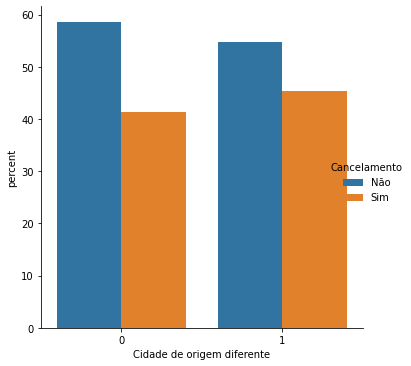

In [6]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_outra_cidade', 'event', 'Cidade de origem diferente')

In [7]:
#print('%.3f'%(proportion_test(df, 'is_outra_cidade')))
print(proportion_test2(df, 'is_outra_cidade'))

0.1217572324307716


# Q2 Taxa de cancelamento é maior para ingressantes no 1o semestre ou 2o semestre letivo? (Ex: taxa de cancelamento é maior para ingressantes em 2019.1 ou 2019.2?)

- Taxa é maior entre ingressantes no 1o semestre (50% vs 34%)
- A diferença é estatisticamente significativa

1    0.687701
2    0.312299
Name: semestreIngresso, dtype: float64
   semestreIngresso  event    percent
0                 1      0  50.125945
1                 1      1  49.874055
2                 2      0  66.164818
3                 2      1  33.835182


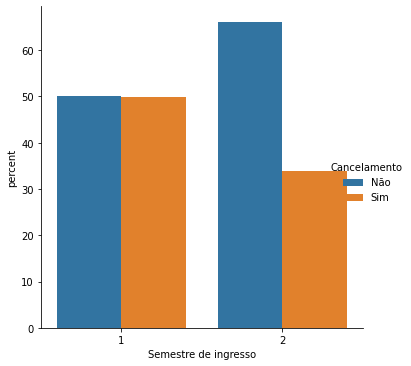

In [8]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['semestreIngresso'].value_counts(normalize=True))

plot_percentage(df[idx], 'semestreIngresso', 'event', 'Semestre de ingresso')

In [9]:
#print('%.3f'%(proportion_test(df, 'periodoingresso')))
print(proportion_test2(df, 'semestreIngresso'))

2.093562211162817e-21


# Q4 Taxa taxa de cancelamento é maior para homens ou mulheres?

- Taxa é maior para homens (50% vs 42%)
- Diferença observada é significativa

0    0.600594
1    0.399406
Name: sexo, dtype: float64
   sexo  event    percent
0     0      0  58.261228
1     0      1  41.738772
2     1      0  50.433705
3     1      1  49.566295


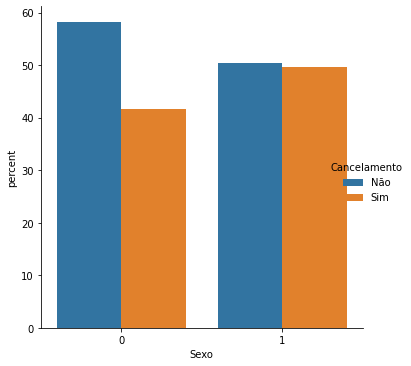

In [10]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['sexo'].value_counts(normalize=True))

plot_percentage(df[idx], 'sexo', 'event', 'Sexo')

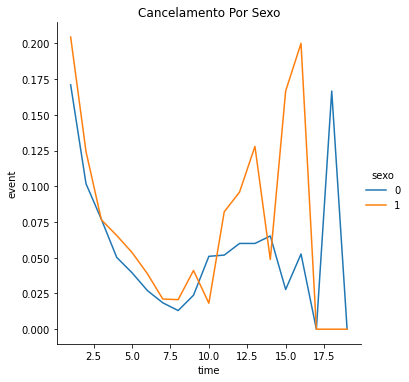

In [11]:
data = df.groupby(['time','sexo']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='sexo',  kind="line")    
ax.set(title='Cancelamento Por Sexo')    

In [12]:
#print('%.3f'%(proportion_test(df, 'sexo')))
print(proportion_test2(df, 'sexo'))

9.582100952002135e-07


# Q5 Taxa de cancelamento decresce com o tempo?

- A taxa tende a decrescer com o tempo

[Text(0.5, 1.0, 'Cancelamento Geral')]

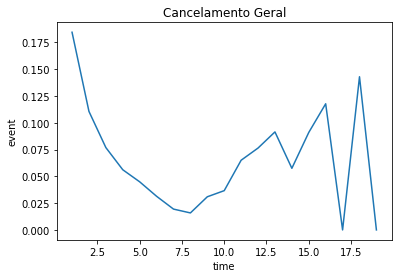

In [13]:
data = df.groupby('time').agg({'event':'mean'}).reset_index()

ax = sns.lineplot(x='time', y='event', data=data)    
ax.set(title='Cancelamento Geral')

# Q6 Taxa de cancelamento difere entre ingressantes por cota e ampla concorrência?

- A taxa é maior para Ampla Concorrência (46% vs 44%)
- A diferença observada não é estatisticamente significativa

0    0.501856
1    0.498144
Name: is_cotista, dtype: float64
   is_cotista  event    percent
0           0      0  53.944773
1           0      1  46.055227
2           1      0  56.333830
3           1      1  43.666170


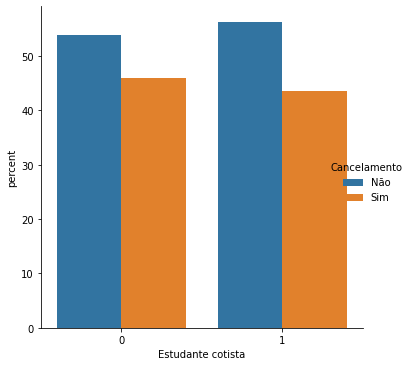

In [14]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_cotista'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_cotista', 'event', 'Estudante cotista')

In [15]:
#print('%.3f'%(proportion_test(df, 'is_cotista')))
print(proportion_test2(df, 'is_cotista'))

0.1268211228664697


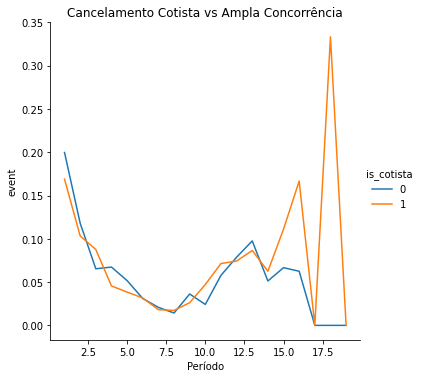

In [16]:
data = df.groupby(['time','is_cotista']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='is_cotista',  kind="line")    
ax.set(title='Cancelamento Cotista vs Ampla Concorrência', xlabel='Período')    

# Q.7 A idade de ingresso afeta a taxa de cancelamento?

- A idade de ingresso parece afetar a taxa

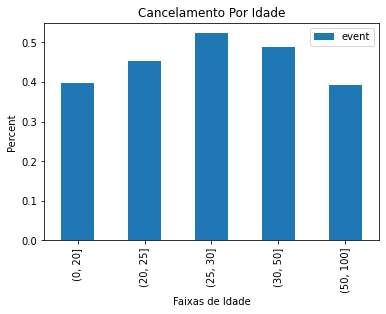

In [17]:
col = 'idade_cat'
df[col] = pd.cut(df.idade_ingresso, bins=[0,20,25,30,50,100])


ax = df[idx].groupby(col).agg({'event':'mean'}).plot.bar()
ax.set(ylabel="Percent")
ax.set(title='Cancelamento Por Idade', xlabel='Faixas de Idade')
plt.show()

# Turno afeta Cancelamento?

In [18]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('turno').agg({'event':'mean'})

,event
turno,
Matutino e Vespertino,0.485852
Noturno,0.422689


# Grau afeta Cancelamento?

In [19]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('grau').agg({'event':'mean'})

,event
grau,
Bacharelado,0.451233
Licenciatura,0.438188
Tecnológico,0.451765


# Análise Bivariada

Idade Ingresso vs Turno


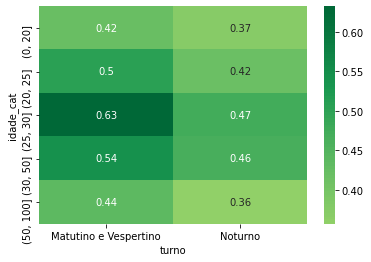

Idade Ingresso vs Grau do Curso


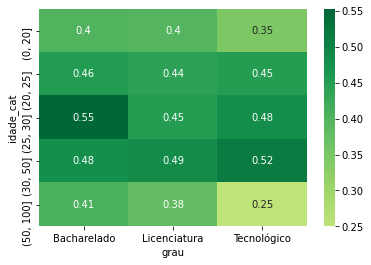

Idade Ingresso vs Sexo


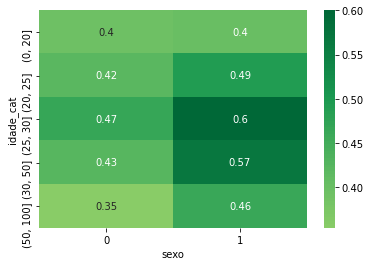

Idade Ingresso vs Cotista


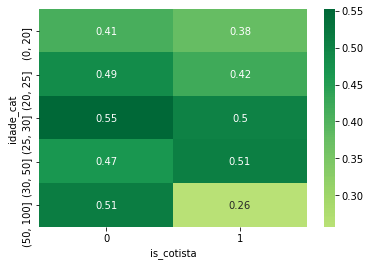

Idade Ingresso vs Migrante


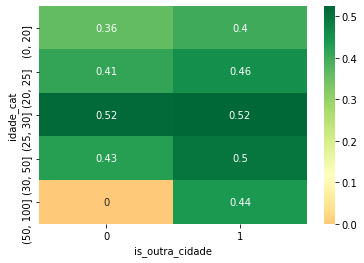

Idade Ingresso vs Período


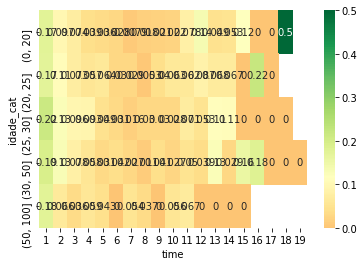

Turno vs Grau do Curso


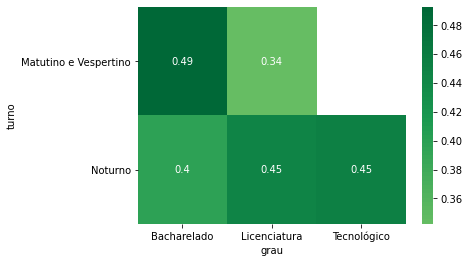

Turno vs Sexo


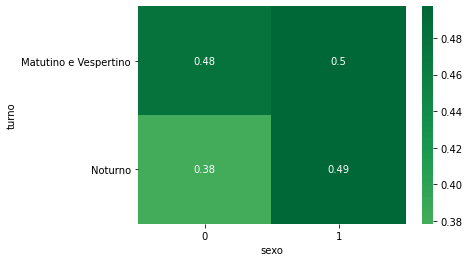

Turno vs Cotista


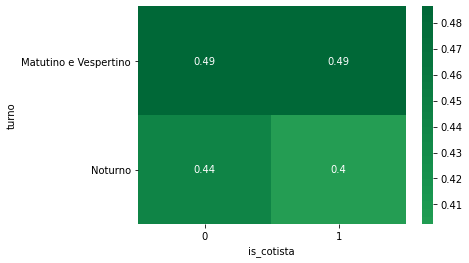

Turno vs Migrante


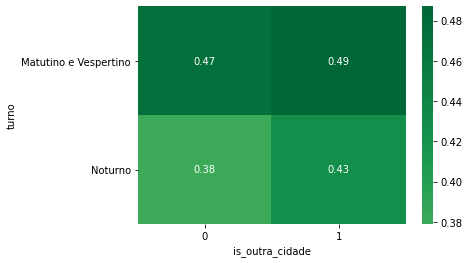

Turno vs Período


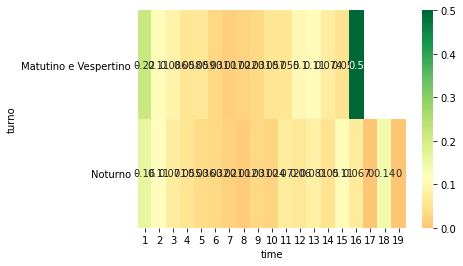

Grau do Curso vs Sexo


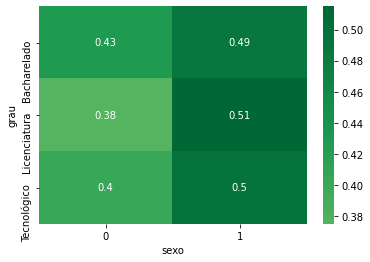

Grau do Curso vs Cotista


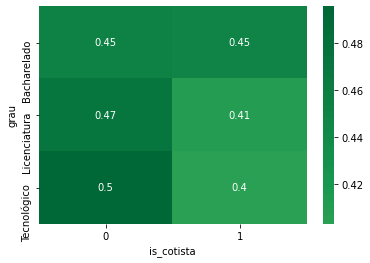

Grau do Curso vs Migrante


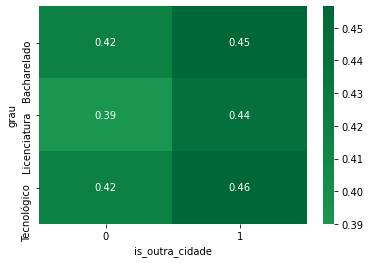

Grau do Curso vs Período


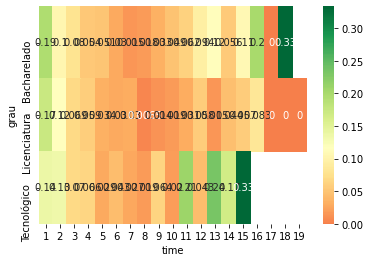

Sexo vs Cotista


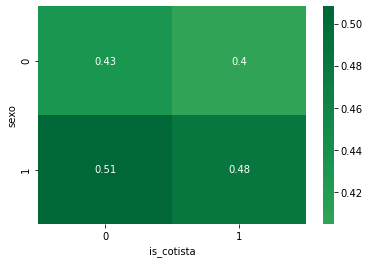

Sexo vs Migrante


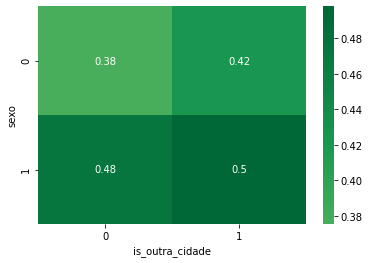

Sexo vs Período


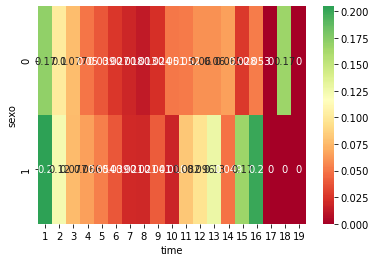

Cotista vs Migrante


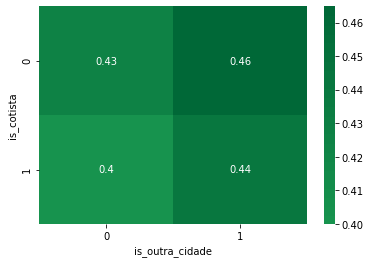

Cotista vs Período


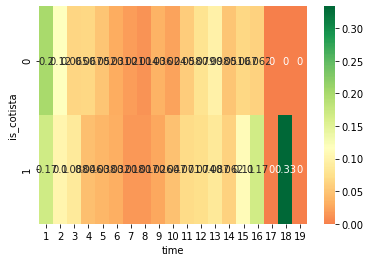

Migrante vs Período


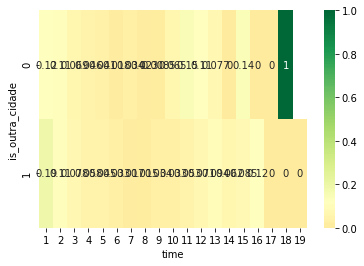

In [20]:
nomes = ['Idade Ingresso', 'Turno', 'Grau do Curso', 'Sexo', 'Cotista', 'Migrante', 'Período']
x = ['idade_cat', 'turno', 'grau', 'sexo', 'is_cotista',  'is_outra_cidade', 'time']

idx = df['time'] == df.groupby('matricula')['time'].transform('max')


for i in range(0, len(x)):
    for j in range(i+1, len(x)):
        print('%s vs %s'%(nomes[i], nomes[j]))
        if x[j] == 'time':
            result = pd.pivot_table(data=df, index=x[i], columns=x[j], values='event')
        else:
            result = pd.pivot_table(data=df[idx], index=x[i], columns=x[j], values='event')
        sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
        plt.show()